In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from unityagents import UnityEnvironment

In [3]:
env = UnityEnvironment(file_name = "Reacher.app", no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])  

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [6]:
# model.py
# Critic and Actor models

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class ActorQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, h_1_size = 256, h_2_size = 128):
        super(ActorQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc_1 = nn.Linear(state_size, h_1_size)
        self.fc_2 = nn.Linear(h_1_size, h_2_size)
        self.output = nn.Linear(h_2_size, action_size)
        self.reset_parameters()

    def forward(self, state):
        y = F.relu(self.fc_1(state))
        y = F.relu(self.fc_2(y))
        return F.tanh(self.output(y))
    
    def reset_parameters(self):
        self.fc_1.weight.data.uniform_(*hidden_init(self.fc_1))
        self.fc_2.weight.data.uniform_(*hidden_init(self.fc_2))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        

class CriticQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, h_1_size = 256, h_2_size = 128):
        super(CriticQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc_1 = nn.Linear(state_size, h_1_size)
        self.fc_2 = nn.Linear(h_1_size + action_size, h_2_size)
        self.output = nn.Linear(h_2_size, 1)
        
    def forward(self, state, action):
        y = F.relu(self.fc_1(state))
        y = torch.cat((y, action), dim=1)
        y = F.relu(self.fc_2(y))
        return self.output(y)
        
        
    def reset_parameters(self):
        self.fc_1.weight.data.uniform_(*hidden_init(self.fc_1))
        self.fc_2.weight.data.uniform_(*hidden_init(self.fc_2))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        
        

In [7]:
# utils
# replaybuffer.py and noise.py
import random 
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [15]:
# ddpg_agent.py file
# agent code
import os
import torch
import torch.optim as optim
# from model import CriticQNetwork, ActorQNetwork
# from replaybuffers import ReplayBuffer

class NewAgent:
    
    def __init__(self, state_size, action_size, num_agents, 
                 seed, 
                 batch_size,
                 buffer_size,
                 actor_lr, 
                 critic_lr, 
                 weight_decay,
                 tau,
                 update_every, gamma, device, 
                 checkpoint_dir="."):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): how many agents are running in each step
            seed (int): random seed
            batch_size (int): how many experience tuples to process at once
            buffer_size (int): size of experience buffer
            actor_lr (float): actor learning rate alpha
            critic_lr (float): critic learning rate alpha
            weight_decay (float): rate of nn weight decay for critic network
            tau (float): soft update rate for synchronizing target and train network weights 
            update_every (int): how many env steps to train agent
            gamma (float): reward discount factor
            device (string): device to run PyTorch computation on (CPU, GPU)
            checkpoint_dir (string) : where to save checkpoints (trained weights)
        """
        self.num_agents = num_agents
        self.seed = torch.manual_seed(seed)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.tau = tau
        
        
        
        self.update_every = update_every
        self.gamma = gamma 
        self.device = device
       
        
        # NN models for 
#         network size 
        hidden_1_size = 256
        hidden_2_size = 128
        
        # Critic 
        self.critic_train     = CriticQNetwork(state_size, action_size, seed, hidden_1_size, hidden_2_size).to(device)
        self.critic_target    = CriticQNetwork(state_size, action_size, seed, hidden_1_size, hidden_2_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_train.parameters(), lr=critic_lr, weight_decay=weight_decay)
        # Actor
        self.actor_train      = ActorQNetwork(state_size, action_size, seed, hidden_1_size, hidden_2_size).to(device)
        self.actor_target     = ActorQNetwork(state_size, action_size, seed, hidden_1_size, hidden_2_size).to(device)
        self.actor_optimizer  = optim.Adam(self.actor_train.parameters(), lr=actor_lr)
        
        # init Noise process
        self.noise = OUNoise((num_agents, action_size), seed)
        
        # init Replay Buffer
        self.memory = ReplayBuffer(action_size= action_size, 
                                   buffer_size=buffer_size,
                                   batch_size=batch_size, 
                                   seed=seed,
                                  device=device)
        
        self.step_counter = 0
        self.actor_loss = 0
        self.critic_loss = 0
        
        #checkpointing
        self.checkpoint_dir   = checkpoint_dir
        
        self.actor_weights = self.checkpoint_dir + "/" + "actor_weights.pth"
        self.critic_weights = self.checkpoint_dir + "/" + "critic_weights.pth"
        
        
    def load_checkpoint(self):
        if os.path.isfile(self.actor_weights) and os.path.isfile(self.critic_weights):
            self.actor_target.load_state_dict(torch.load(self.actor_weights))
            self.actor_train.load_state_dict(torch.load(self.actor_weights))
            self.critic_target.load_state_dict(torch.load(self.critic_weights))
            self.critic_train.load_state_dict(torch.load(self.critic_weights))
            
    def save_checkpoint(self, file_name=None):
        actor_weights =  file_name + "_actor_weights.pth"  if prefix else self.actor_weights
        critic_weights = file_name + "_critic_weights.pth" if prefix else self.critic_weights
        torch.save(self.actor_train.state_dict(), actor_weights)      
        torch.save(self.critic_train.state_dict(), critic_weights)  

    def act(self, states, add_noise = True):
        states = torch.from_numpy(states).float().to(self.device)
        self.actor_train.eval()
        with torch.no_grad():
            actions = self.actor_train(states).cpu().data.numpy()
        self.actor_train.train()
        
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def step(self, states, actions, rewards, next_states, dones):
        [self.memory.add(s, a, r, s_next, d) for (s, a, r, s_next, d) 
                in zip(states, actions, rewards, next_states, dones)]
        
        self.step_counter += 1
        if len(self.memory) >= self.batch_size:
            self.learn(self.memory.sample())
    
    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
       
        # Critic training
        target_actions_pred = self.actor_target(next_states)
        target_pred = self.critic_target(next_states, target_actions_pred)
        Q_target = rewards + (self.gamma * target_pred * (1 - dones))
        
        Q_pred = self.critic_train(states, actions)
        
        self.critic_optimizer.zero_grad()
        critic_loss = F.mse_loss(Q_pred, Q_target)
        self.critic_loss = critic_loss.data
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Actor training 
        actions_pred = self.actor_train(states)
        actor_loss = -self.critic_train(states, actions_pred).mean()
        self.actor_loss = actor_loss.data
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.critic_train, self.critic_target, self.tau)
        self.soft_update(self.actor_train, self.actor_target, self.tau)
        
        
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        


In [10]:
def plot_scores_losses(scores, mean_scores, actor_losses, critic_losses):
    import matplotlib.pyplot as plt

    # len(agent.losses)

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

    ax11 = fig.add_subplot(2, 1, 2)
    plt.plot(np.arange(len(mean_scores)), mean_scores)
    plt.ylabel('Mean Score')
    plt.xlabel('Episode #')
    plt.show()

    ax2 = fig.add_subplot(2, 2, 3)
    plt.plot(np.arange(len(actor_losses)), actor_losses)
    plt.ylabel('Actor Losses')
    plt.xlabel('Steps #')
    plt.show()

    ax3 = fig.add_subplot(2, 2, 4)
    plt.plot(np.arange(len(critic_losses)), critic_losses)
    plt.ylabel('Critic Losses')
    plt.xlabel('Steps #')
    plt.show()

def train_multiple_agents(num_agents, agent, env, output_weights, target_mean_score=13.0, n_episodes = 1000, eps_decay=0.99, eps_end=0.01, input_weights = None):
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    if input_weights:
        print(input_weights)
        agent.load_model_weights(input_weights)
    
    scores = []
    mean_scores = []
    actor_losses = []
    critic_losses = []
    eps = 0.9
    # actor_losses_window = deque(maxlen=100)
    # critic_losses_window = deque(maxlen=100)
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1,n_episodes+1):
        # print("Episonde {} start".format(i_episode), end="")

        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
        states = env_info.vector_observations               # get the current state
        score = 0                                           # initialize the score
        done = False                                          
        while not(done):                                 # exit loop if episode finished
            actions =  agent.act(states, add_noise=True)                 # select an action
            # print(actions, actions.shape)
            env_info = env.step(actions)[brain_name]      # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones) 
                    
            actor_losses.append(agent.actor_loss)
            critic_losses.append(agent.critic_loss)
            score += np.mean(rewards)                           # update the score
            states = next_states                             # roll over the state to next time step
            done = np.any(dones)

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay*eps)
        mean_score = np.mean(scores_window)
        mean_scores.append(mean_score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score, eps), end="")
        agent.save_checkpoint()
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            plot_scores_losses(scores, mean_scores, actor_losses, critic_losses)
        if mean_score >= target_mean_score:
            print("Target mean score of {:.2f} achived at {:.2f} after {} episodes.".format(target_mean_score, mean_score, i_episode))
                #     print("Score: {}".format(score))
            agent.save_checkpoint(path=output_weights)
            
            break
    return scores

In [16]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters               
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic

UPDATE_EVERY = 1        # how often to update the network
WEIGHT_DECAY = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = NewAgent(state_size  = state_size, 
                 action_size = action_size, 
                 num_agents = num_agents,
                 seed=2,
                batch_size=BATCH_SIZE,
                buffer_size=BUFFER_SIZE,
                actor_lr=LR_ACTOR,
                critic_lr=LR_CRITIC,
                weight_decay=WEIGHT_DECAY,
                tau=TAU,
                update_every=UPDATE_EVERY,
                gamma = GAMMA,
                device = device,
                checkpoint_dir = "checkpoints")

Episode 10	Average Score: 1.01


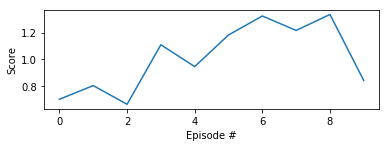

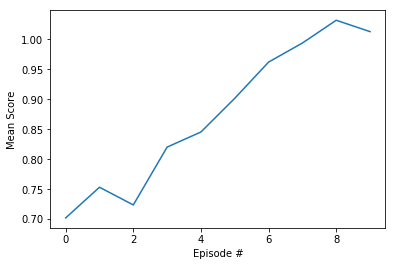

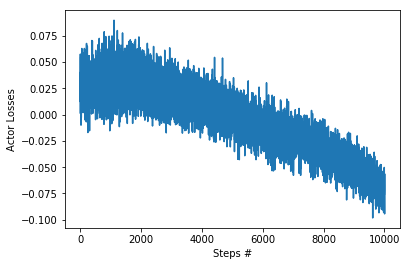

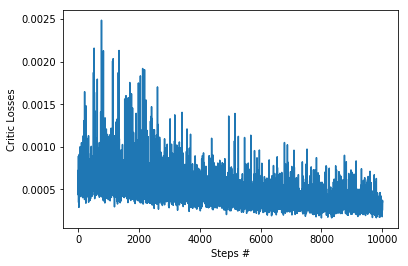

Episode 20	Average Score: 1.19


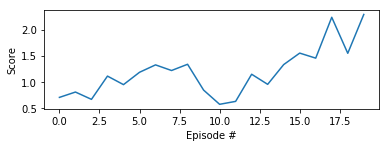

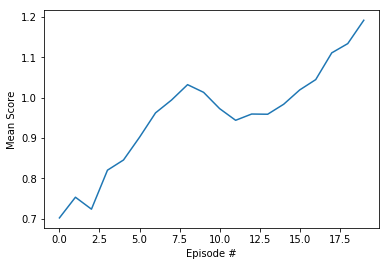

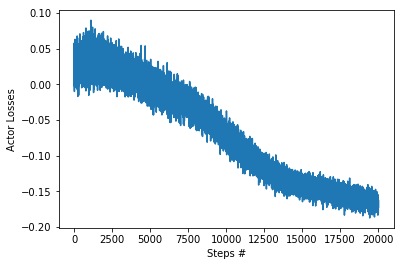

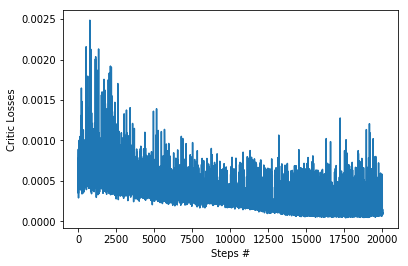

Episode 30	Average Score: 1.89


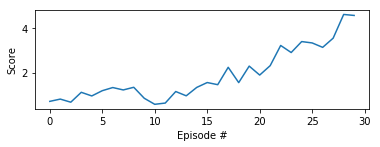

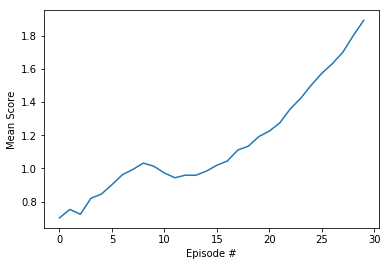

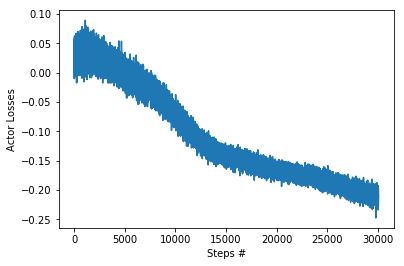

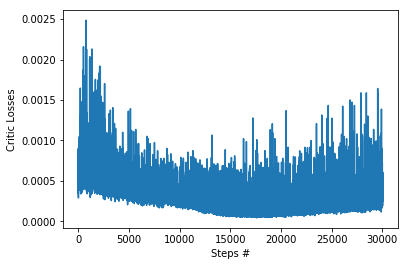

Episode 40	Average Score: 3.85


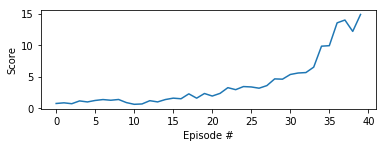

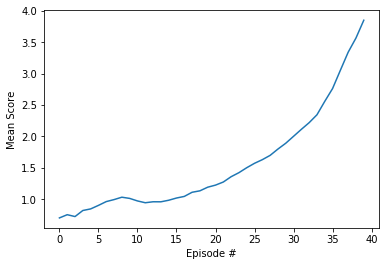

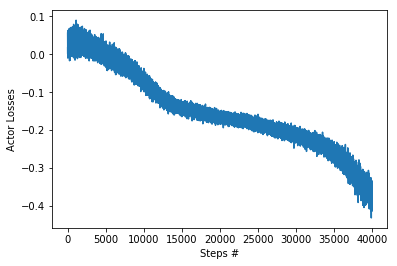

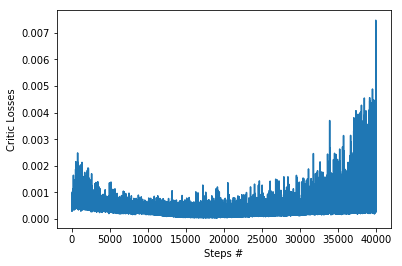

Episode 50	Average Score: 6.98


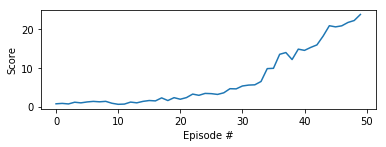

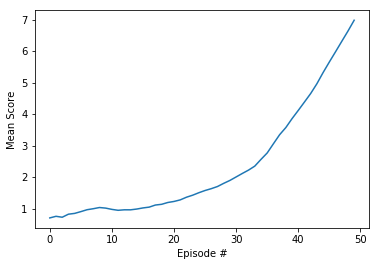

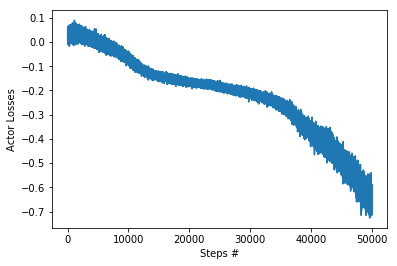

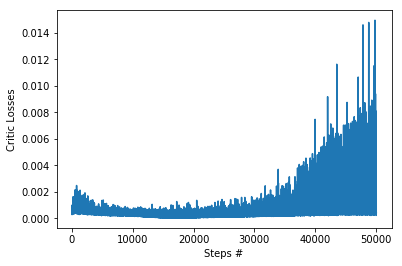

Episode 60	Average Score: 10.18


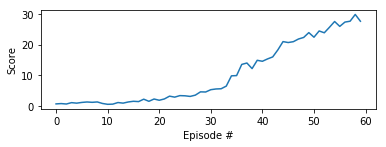

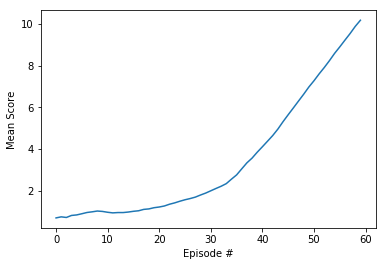

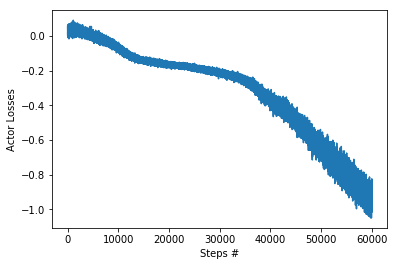

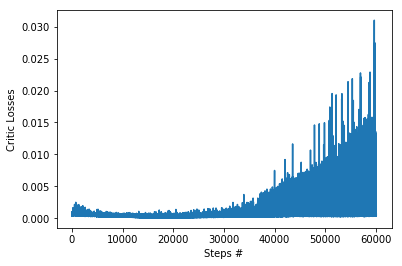

Episode 70	Average Score: 13.44


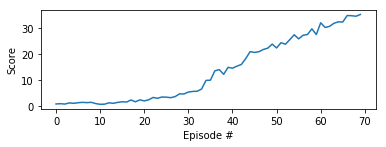

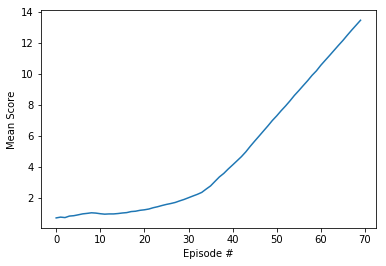

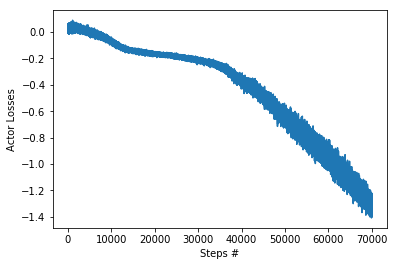

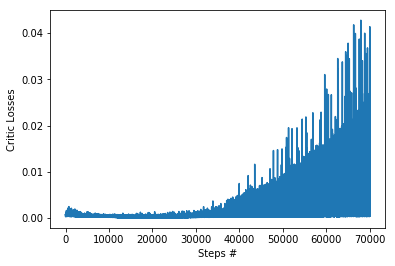

Episode 80	Average Score: 16.31


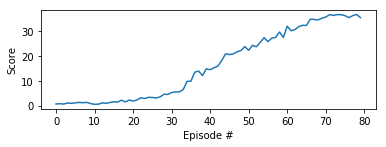

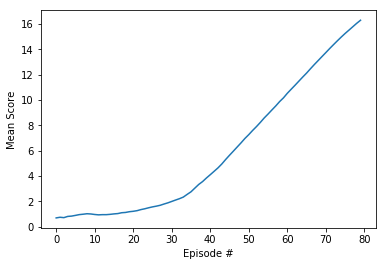

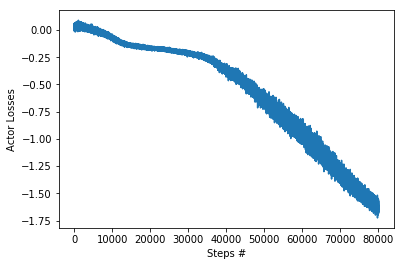

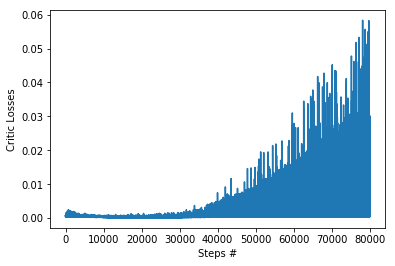

Episode 90	Average Score: 18.53


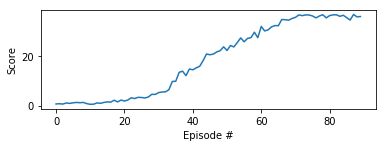

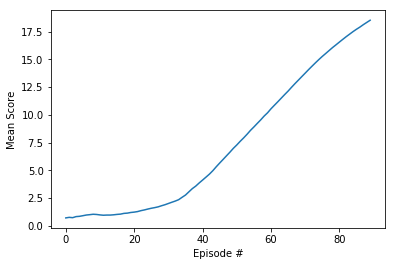

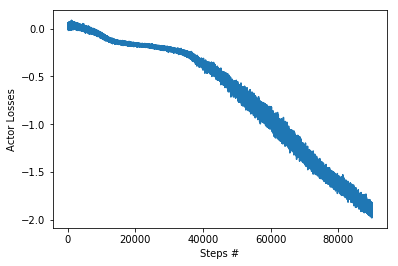

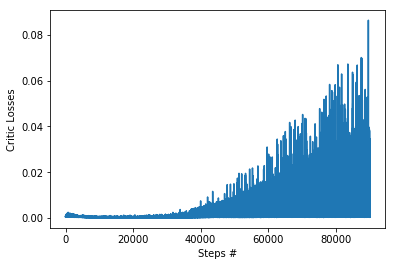

Episode 100	Average Score: 20.22


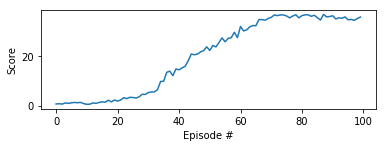

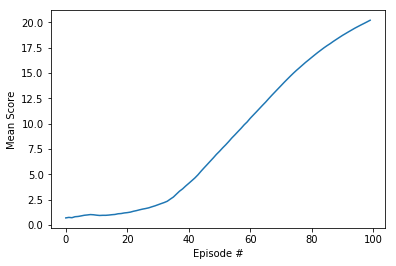

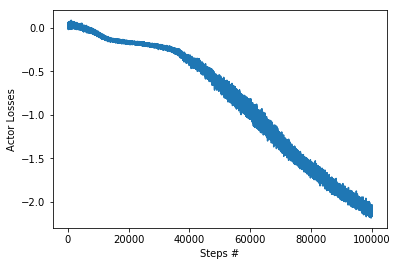

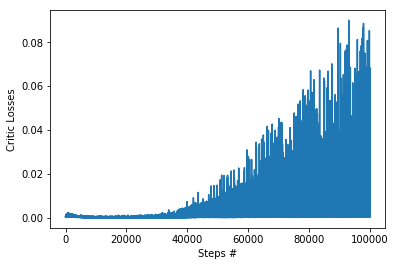

Episode 110	Average Score: 23.72


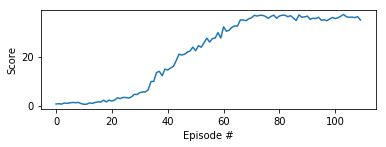

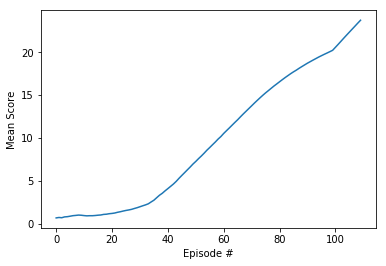

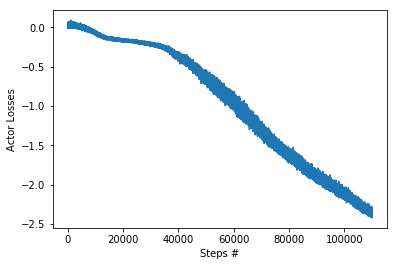

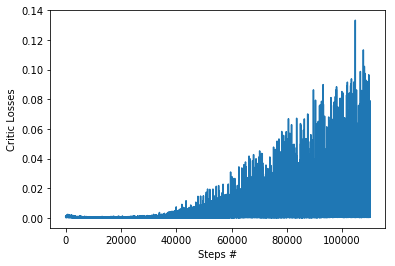

Episode 120	Average Score: 27.04


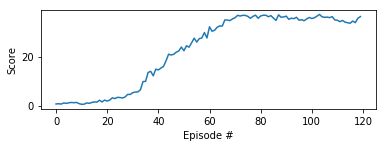

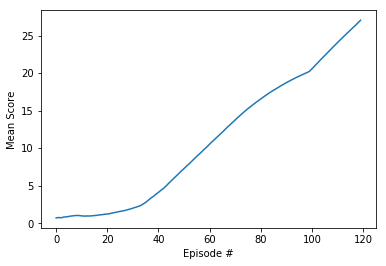

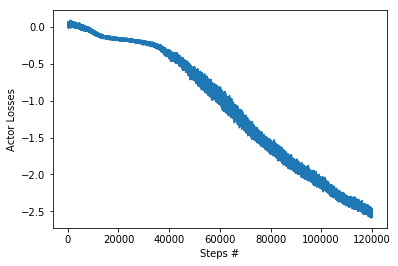

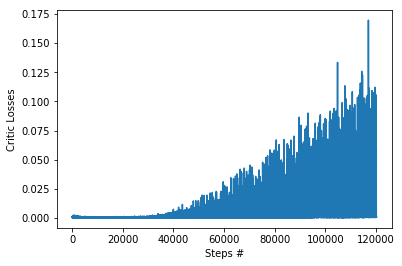

Episode 130	Average Score: 30.30


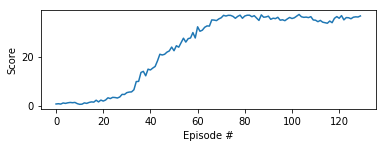

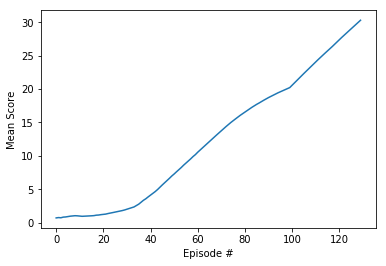

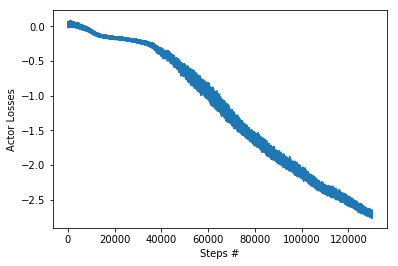

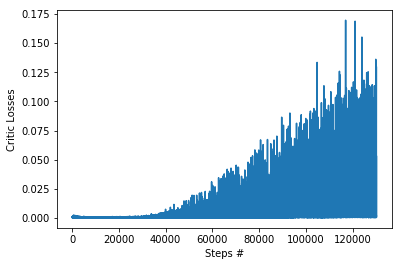

Target mean score of 30.00 achived at 30.30 after 130 episodes.
Saving model weights to final_weights.pth


AttributeError: 'NewAgent' object has no attribute 'qnetwork_local'

In [18]:
train_multiple_agents(num_agents, agent, env, 
                      target_mean_score=30.0, 
                      output_weights="final_weights.pth", 
                      n_episodes=200)

In [12]:
actions =  agent.act(states, add_noise=True)                 # select an action
            # print(actions, actions.shape)
env_info = env.step(actions)[brain_name]      # send the action to the environment
next_states = env_info.vector_observations   # get the next state
rewards = env_info.rewards                   # get the reward
dones = env_info.local_done                  # see if episode has finished
# agent.step(states, actions, rewards, next_states, dones) 



In [13]:
agent.memory.memory.maxlen

100000

In [14]:
for (s, a, r, s_next, d) in zip(states, actions, rewards, next_states, dones):
    print(len(agent.memory))
    agent.memory.add(s, a, r, s_next, d)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [82]:
agent.act(states)

array([[ 0.19015642,  0.05220285,  0.1587571 ,  0.36229968],
       [ 0.07650984, -0.03591636, -0.00476222, -0.37642184],
       [ 0.11308827, -0.6802681 ,  0.81197274, -0.49480435],
       [-0.01364741,  0.08516264, -0.05186343, -0.70540637],
       [ 0.5135801 , -0.02349785, -0.02693737, -0.20713241],
       [-0.0902632 ,  0.60481685, -0.08271424,  0.08269405],
       [ 0.5401794 ,  0.16245046,  0.17905343, -0.04830385],
       [ 0.32272345, -0.9119885 , -0.5256016 ,  0.64664024],
       [ 0.4783802 , -0.6239626 ,  0.38052094,  0.0427371 ],
       [ 0.19037928,  0.04520654, -0.00859364, -0.6948075 ],
       [-0.26801077,  0.23406217, -0.8532971 , -0.27996698],
       [ 0.0816713 , -0.14413047,  0.30066088, -0.26381555],
       [-0.34165612,  0.10452893,  0.18002029, -0.20419249],
       [-0.01218016,  0.54233116,  0.48644128,  0.04685143],
       [ 0.02191565, -0.24165398, -0.7420052 ,  0.27222112],
       [ 0.00346508,  0.40783632,  0.19831266, -0.02575582],
       [-0.01272164, -0.

In [31]:
ac = ActorQNetwork(state_size, action_size, seed=2, h_1_size=256, h_2_size=128)
cr = CriticQNetwork(state_size, action_size, seed=2, h_1_size=256, h_2_size=128)

In [32]:
states_t = torch.from_numpy(states).float()
actions_t = ac(states_t )
cr(states_t, actions_t)

tensor([[-0.4351],
        [ 0.1482],
        [-0.3331],
        [ 0.0975],
        [-0.3457],
        [ 0.1651],
        [-0.4083],
        [ 0.0466],
        [ 0.0905],
        [-0.2108],
        [-0.0150],
        [-0.2719],
        [-0.4074],
        [ 0.1377],
        [-0.3941],
        [-0.2996],
        [-0.2419],
        [-0.1977],
        [-0.2814],
        [ 0.0697]])

In [33]:
y1 = F.relu(cr.fc_1(states_t)) # Y = W*XT + b ->  (256, 33) = (256, 33) * (33, 20) + (256,1)
y2 = torch.cat((y1,actions_t), dim=1)         #-> (20, 260) = (20, 256) concat (20, 4)
y3 = F.relu(cr.fc_2(y2))
states_t.shape, actions_t.shape, y1.shape, y2.shape 

(torch.Size([20, 33]),
 torch.Size([20, 4]),
 torch.Size([20, 256]),
 torch.Size([20, 260]))